# Prepare data

In [3]:
USE_SUBSET = True

In [4]:
import pandas as pd
from fastai.vision.all import *
from random import sample


In [5]:
df_articles = pd.read_parquet("Data/processed_articles.parquet")
df_articles.head()

,article_id,product_code,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,value_binned,path
0,0108775015,0108775,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,4,Rawdata/images/010/0108775015.jpg
1,0108775044,0108775,Strap top,Vest top,Garment Upper body,Solid,White,Light,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,4,Rawdata/images/010/0108775044.jpg
2,0108775051,0108775,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,4,Rawdata/images/010/0108775051.jpg
3,0110065001,0110065,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.",4,Rawdata/images/011/0110065001.jpg
4,0110065002,0110065,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.",4,Rawdata/images/011/0110065002.jpg


# Get relevant product groups

In [6]:
counts = df_articles["product_group_name"].value_counts()
counts

Garment Upper body       42483
Garment Lower body       19701
Garment Full body        13215
Accessories              10947
Underwear                 5444
Shoes                     5125
Swimwear                  3125
Socks & Tights            2424
Nightwear                 1894
Unknown                    116
Underwear/nightwear         54
Cosmetic                    47
Bags                        25
Items                       15
Furniture                   13
Garment and Shoe care        9
Stationery                   5
Interior textile             3
Fun                          2
Name: product_group_name, dtype: int64

In [7]:
relevant_groups = ["Garment Upper body", "Garment Lower body", "Garment Full body", "Accessories"]
df_articles = df_articles[df_articles["product_group_name"].isin(relevant_groups)]
df_articles["product_group_name"].value_counts()

Garment Upper body    42483
Garment Lower body    19701
Garment Full body     13215
Accessories           10947
Name: product_group_name, dtype: int64

# Prepare a final pandas dataframe

In [8]:
df = df_articles[["article_id", "product_code", "path", "product_group_name"]]
df.head()


,article_id,product_code,path,product_group_name
0,0108775015,0108775,Rawdata/images/010/0108775015.jpg,Garment Upper body
1,0108775044,0108775,Rawdata/images/010/0108775044.jpg,Garment Upper body
2,0108775051,0108775,Rawdata/images/010/0108775051.jpg,Garment Upper body
8,0111586001,0111586,Rawdata/images/011/0111586001.jpg,Garment Lower body
11,0112679048,0112679,Rawdata/images/011/0112679048.jpg,Garment Upper body


# Subset the data

In [9]:
if USE_SUBSET:
    df = df.groupby(['product_group_name']).apply(lambda x: x.sample(frac=0.25)) 
    df = df.drop(columns=['product_group_name']).reset_index().drop(columns=['level_1'])
    print(df["product_group_name"].value_counts())

Garment Upper body    10621
Garment Lower body     4925
Garment Full body      3304
Accessories            2737
Name: product_group_name, dtype: int64


# Train / Test Split
 we want to do a stratified split on the product code

In [10]:
unique_values = list(df["product_code"].unique())
k = round(len(unique_values) * 0.2)
sample_result = sample(unique_values, k)
df_samples = pd.DataFrame(sample_result, columns=['product_code'])
df_samples["is_valid"] = False
df = df.merge(df_samples, on='product_code', how='left')
df['is_valid'] = df['is_valid'].fillna(True)
df.head()

,product_group_name,article_id,product_code,path,is_valid
0,Accessories,0800791001,0800791,Rawdata/images/080/0800791001.jpg,True
1,Accessories,0751717001,0751717,Rawdata/images/075/0751717001.jpg,False
2,Accessories,0630876002,0630876,Rawdata/images/063/0630876002.jpg,True
3,Accessories,0888988006,0888988,Rawdata/images/088/0888988006.jpg,True
4,Accessories,0760100001,0760100,Rawdata/images/076/0760100001.jpg,True


In [11]:
# refactor get_x and get_y to functions if we want to serialize the learner later
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=ColSplitter(col='is_valid'),
    get_x=lambda r: r["path"],
    get_y=lambda r: r["product_group_name"],
    item_tfms=RandomResizedCrop(128),
    batch_tfms=aug_transforms(),
)


In [12]:
dls = dblock.dataloaders(df, bs=128)

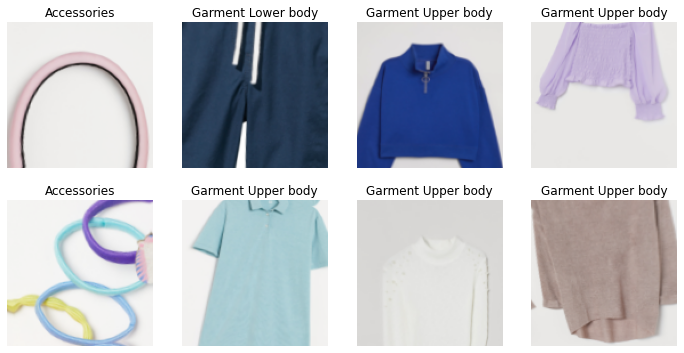

In [13]:
dls.train.show_batch(ncols=4, nrows=2)

In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.610448,0.702564,0.225532,02:48


epoch,train_loss,valid_loss,error_rate,time
0,1.014454,0.510488,0.164107,02:00
1,0.845315,0.468115,0.146259,02:09
2,0.743386,0.429438,0.140639,01:59


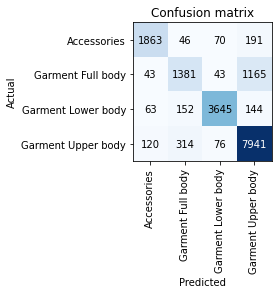

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


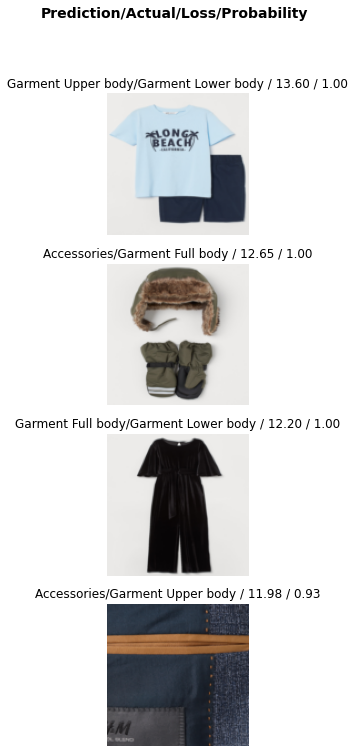

In [17]:
interp.plot_top_losses(4, nrows=4)
